# Unseen Object Instance Segmentation

In [73]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

## Depth Seeding Network Parameters

In [74]:
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

## Region Refinement Network parameters

In [75]:
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

# UOIS-Net-3D Parameters

In [76]:
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

In [77]:
checkpoint_dir = 'checkpoints/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


In [78]:
import torch

print(torch.cuda.is_available())

True


## Run on example OSD/OCID images

We provide a few [OSD](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/osd/) and [OCID](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/object-clutter-indoor-dataset/) images and run the network on them. Evaluation metrics are shown for each of the images.

In [104]:
example_images_dir = os.path.abspath('.') + '/example_images/'

OSD_image_files = sorted(glob.glob(example_images_dir + '/OSD_image_0.npy'))
OCID_image_files = sorted(glob.glob(example_images_dir + '/OCID_image_0.npy'))
N = len(OSD_image_files) + len(OCID_image_files)

rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
label_imgs = np.zeros((N, 480, 640), dtype=np.uint8)

for i, img_file in enumerate(OSD_image_files + OCID_image_files):
    d = np.load(img_file, allow_pickle=True, encoding='bytes').item()
    
    # RGB
    rgb_img = d['rgb']
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    xyz_imgs[i] = d['xyz']

    # Label
    label_imgs[i] = d['label']
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

[[[178 178 204]
  [178 178 204]
  [178 178 204]
  ...
  [178 178 204]
  [178 178 204]
  [178 178 204]]

 [[178 178 204]
  [178 178 204]
  [178 178 204]
  ...
  [178 178 204]
  [178 178 204]
  [178 178 204]]

 [[178 178 204]
  [178 178 204]
  [178 178 204]
  ...
  [178 178 204]
  [178 178 204]
  [178 178 204]]

 ...

 [[160 184 221]
  [160 184 221]
  [160 184 221]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[160 184 221]
  [160 184 221]
  [160 184 221]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[160 184 221]
  [160 184 221]
  [160 184 221]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]]
(720, 1280, 3) (720, 1280, 3)


WARNING - 2022-01-14 04:40:41,886 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 1280, 3)


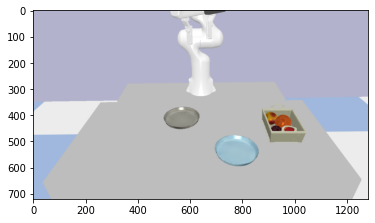

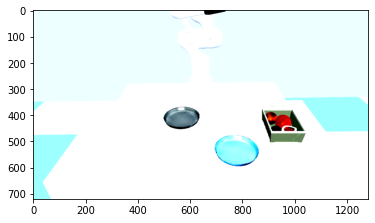

In [111]:
# load the rgb and the point cloud for the OCRTOC challenge
import cv2

image = cv2.imread('example_images/kin_image.png')
rgb_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(rgb_converted)
plt.figure()
plt.imshow(rgb_converted)
rgb_image = data_augmentation.standardize_image(rgb_converted)
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape, rgb_image.shape)

# read the pcd file to get the depth information 
import open3d as o3d

pcd = o3d.io.read_point_cloud("example_images/custom.pcd")
out_arr = np.asarray(pcd.points)  
out_arr = out_arr.reshape(720, 1280, 3)
o3d.visualization.draw_geometries([pcd])
print(out_arr.shape)

plt.figure()
plt.imshow(rgb_image)

N = 1 # indicates the number of images
rgb_imgs = np.zeros((N, 720, 1280, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 720, 1280, 3), dtype=np.float32)

rgb_imgs[0] = rgb_image
xyz_imgs[0] = out_arr

In [112]:
batch = {
    'rgb': data_augmentation.array_to_tensor(rgb_imgs),
    'xyz': data_augmentation.array_to_tensor(xyz_imgs),
}

In [113]:
print(batch['rgb'].shape)
print(batch['xyz'].shape)
print(label_imgs.shape) # there are 2 images and the label is given for the image? 
# print(label_imgs)

torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 720, 1280])
(2, 480, 640)


In [114]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

Number of images: 1
Total time taken for Segmentation: 4.216 seconds
FPS: 0.237


(1, 720, 1280)


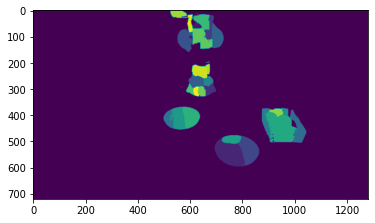

In [115]:
# The seg_masks has the information regarding the segmentation mask 
print(seg_masks.shape) # there are two images each of dimension height x width 
plt.imshow(seg_masks[0])
# plt.figure()
# plt.imshow(seg_masks[1])

Image 1 Metrics:


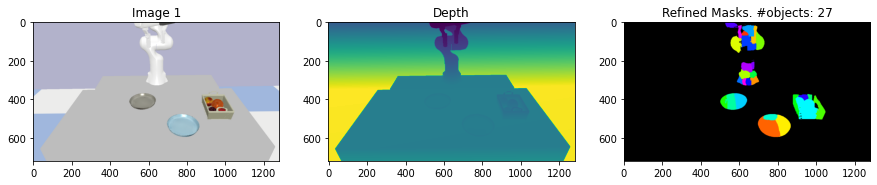

In [116]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(1):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
#     gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
#     images = [rgb, depth, seg_mask_plot, gt_masks]
    images = [rgb, depth, seg_mask_plot]
#     titles = [f'Image {i+1}', 'Depth',
#               f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
#               f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
#              ]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}"
             ]

    util_.subplotter(images, titles, fig_num=i+1)
    
    # Run evaluation metric
#     eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...])
    print(f"Image {i+1} Metrics:")
#     print(eval_metrics)

ValueError: operands could not be broadcast together with shapes (720,1280) (480,640) 

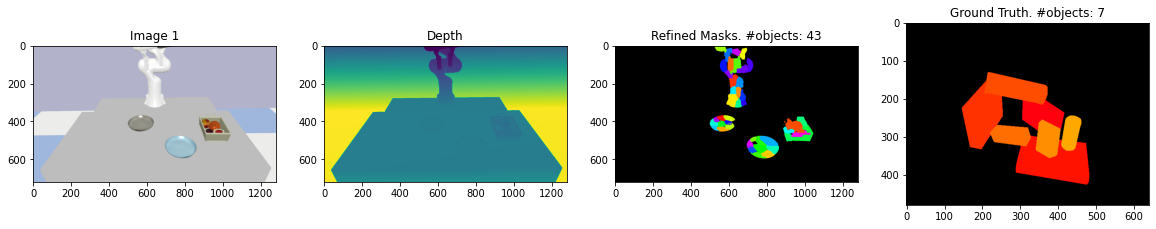

In [99]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(1):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1)
    
    # Run evaluation metric
    eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    print(f"Image {i+1} Metrics:")
    print(eval_metrics)

(720, 1280, 3)
[  0  14  18  32  41  50  59  74  77  91 106 110 123 124 133 142 143 150
 156 166 169 175 182 183 199 201 202 215 216 218 226 234 235 241 248 251
 255] [2625998     696    2964    2680     740    3402    5543    1801    5849
    4228    1947    3883    1794     672    1186    1301    1869    1200
    1840     636    1221    3292    2051    1138    1319    1945     641
    1147    1300     802     999    3077    1171    1315    1551    1056
   70546]
37
Boolean mask : (720, 1280, 3)
Original image : (720, 1280, 3)
1280 720
3 1280 720
Segmented object : (720, 1280, 3)


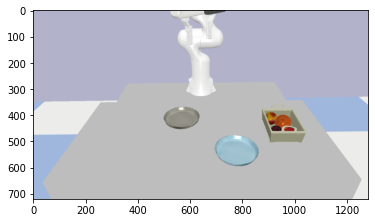

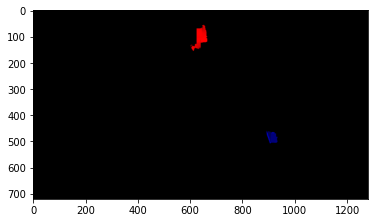

In [100]:
# we have information regarding how many objects are in the scene -> given by num_objects 
print(seg_mask_plot.shape)
# plt.imshow(seg_mask_plot)
unique, counts = np.unique(seg_mask_plot, return_counts=True)
print(unique, counts)
print(len(counts)) # The number of objects in the scene is 10
boolean_mask = seg_mask_plot == 91
# print(boolean_mask)
print(f'Boolean mask : {boolean_mask.shape}')
original_image = images[0]
# print(original_image)
plt.figure()
plt.imshow(original_image)
print(f'Original image : {original_image.shape}')
print(len(boolean_mask[0]), len(boolean_mask))
print(boolean_mask.shape[2], boolean_mask.shape[1], boolean_mask.shape[0])

# segmented_object = [[original_image[i][j] if boolean_mask[i][j].any() == True else 0 for j in range(len(boolean_mask[0]))] for i in range(len(boolean_mask))]
segmented_object = [[[original_image[i][j][k] if boolean_mask[i][j][k] == True else 0 for k in range(boolean_mask.shape[2])] for j in range(boolean_mask.shape[1])] for i in range(boolean_mask.shape[0])]
# plt.imshow(another)
s = np.asarray(segmented_object, dtype=int)
print(f'Segmented object : {s.shape}')
# print(s)
plt.figure()
plt.imshow(s)

Seg mask plot : (480, 640, 3)
(480, 640)
Segmented object : (480, 640, 3)
TwoD image shape : (480, 640)
[[170 173 189 ...   0   0   0]
 [171 180 180 ...   0   0   0]
 [173 187 171 ...   0   0   0]
 ...
 [110 106 104 ...   0   0   0]
 [109 105 108 ...   0   0   0]
 [106 103 105 ...   0   0   0]]
Min y : 148, max y : 256, minX : 166, maxX: 332
Cropped shape : (166, 108, 3)


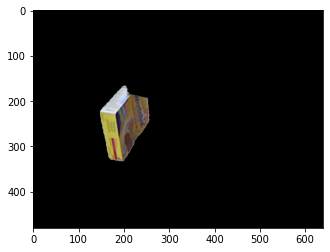

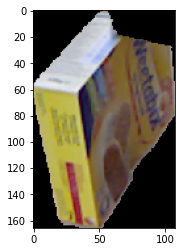

In [92]:
pixel_to_check = 91
print(f'Seg mask plot : {seg_mask_plot.shape}')
mask = seg_mask_plot[..., 0] != pixel_to_check
# find the number of entries that do not have the mask set

print(mask.shape)

masked_copy = original_image.copy()
masked_copy[mask] = 0
segmented_object = np.asarray(masked_copy)
print(f'Segmented object : {segmented_object.shape}')
plt.figure()
plt.imshow(segmented_object)

# create a bounding box around the object by finding the minimum and maximum x and y coordinates 
# corresponding to the pixel value 
twoD_image = segmented_object[:, :, 0]
print(f'TwoD image shape : {twoD_image.shape}')
print(twoD_image[200:300,200:300])

# find the minimum y value 
cols = np.array([twoD_image[:, i] for i in range(twoD_image.shape[1])])
minY, maxY, minX, maxX = 0, 0, 0, 0

for i in range(twoD_image.shape[1]):
    # find the column corresponding to the twoD_image 
    col = twoD_image[:, i]
    # find if any of the pixel values correspond to non-0 value 
    if col.any() != 0:
        minY = i
        break
        
for i in range(twoD_image.shape[1]-1, 1, -1):
    col = twoD_image[:, i]
    if col.any() != 0:
        maxY = i
        break

for i in range(twoD_image.shape[0]):
    row = twoD_image[i, :]
    if row.any() != 0:
        minX = i
        break
        
for i in range(twoD_image.shape[0] - 1, 1, -1):
    row = twoD_image[i, :]
    if row.any() != 0:
        maxX = i
        break
        
print(f'Min y : {minY}, max y : {maxY}, minX : {minX}, maxX: {maxX}')
# crop out the image 
cropped = segmented_object[minX:maxX, minY:maxY, :]
print(f'Cropped shape : {cropped.shape}')
plt.figure()
plt.imshow(cropped)

4
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(480, 640, 3)
2
(480, 640)


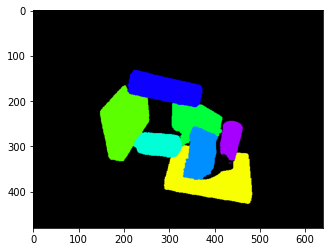

In [86]:
# The mask is being generated for all the objects in the image 
print(len(images)) # there are 4 images because of printing the original image, depth map, masks and ground truth
seg_mask_plot = images[2]
print(seg_mask_plot)
print(seg_mask_plot.shape)
plt.imshow(seg_mask_plot)
print(len(label_imgs))
print(label_imgs[0].shape) # the dimension of the image